**AB2 Method**

In [1]:
import numpy as np

# Define equations of motion
def equations(t, y, rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi):
    x, vx, h, vy = y
    theta = np.arctan((vw - vx) / -vy)
    ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
          + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
         - 2 * np.cos(phi) * omega * vy
    ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
          + 0.5 * rho * vy**2 * cb * pi * (D/2)**2 - m * g) / m \
         + 2 * np.cos(phi) * omega * vx
    return np.array([vx, ax, vy, ay])

# AB 2-step integrator
def ab2_integrate(func, t_span, y0, dt, args):
    t0, tf = t_span
    n_steps = int((tf - t0) / dt)
    t_values = np.linspace(t0, tf, n_steps + 1)
    y_values = np.zeros((len(y0), n_steps + 1))
    y_values[:, 0] = y0

    # First step using Forward Euler to start AB2
    f0 = func(t_values[0], y0, *args)
    y_values[:, 1] = y0 + dt * f0
    f1 = func(t_values[1], y_values[:, 1], *args)

    # Main AB2 loop
    for k in range(1, n_steps):
        y_values[:, k + 1] = y_values[:, k] + dt * (1.5 * f1 - 0.5 * f0)
        f0, f1 = f1, func(t_values[k + 1], y_values[:, k + 1], *args)

    return t_values, y_values

# Function to find minimum parachute radius using AB2 integration
def find_min_radius_ab2(rho, vw, cp, cb, cw, D, L, m, phi, g, omega, pi, max_vy, x0, vx0, h0, vy0):
    r = 0.005
    dt = 0.01  # chosen from Δt-sensitivity study
    t_span = (0, 50)

    while True:
        y0 = np.array([x0, vx0, h0, vy0])
        t_eval, y_eval = ab2_integrate(equations, t_span, y0, dt,
                                       (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi))
        vy_vals = y_eval[3, :]
        if np.max(np.abs(vy_vals)) < max_vy:
            return r
        r += 0.005

# constants
rho = 1.225
g = 9.81
omega = 7.292e-5
pi = np.pi
x0 = 0
vy0 = -0.1
cp = 1.3
cb = 0.8
cw = 1.0

# user inputs
vw0 = float(input("Enter wind speed (m/s): "))
wsf = float(input("Enter wind safety factor: "))
D = float(input("Enter diameter of rocket (cm): ")) / 100
L = float(input("Enter length of rocket (cm): ")) / 100
m = float(input("Enter mass of rocket (g): ")) / 1000
phi = np.deg2rad(float(input("Enter latitude of launch site (degrees): ")))
vx0 = float(input("Enter horizontal velocity at apogee (m/s): "))
h00 = float(input("Enter altitude at apogee (m): "))
hsf = float(input("Enter altitude safety factor: "))
max_vy = abs(float(input("Enter max allowable vertical velocity (m/s) (2–5 m/s suggested): ")))

# setup
vw = vw0 * wsf
h0 = h00 * hsf

# run AB2 simulation
min_r = find_min_radius_ab2(rho, vw, cp, cb, cw, D, L, m, phi, g, omega, pi, max_vy, x0, vx0, h0, vy0)
print(f"Minimum parachute radius required: {round(min_r * 100, 1)} cm")
# Test inputs
# wind speed 10 m/s
# WSF 2
# diameter 10
# length 50
# mass 1000 g
# latitude 20 degs
# vxo 10 m/s
#h00 500 m
# hsf 1
# max vy 2 m/s
# OUTPUT 105 cm


Enter wind speed (m/s): 10
Enter wind safety factor: 2
Enter diameter of rocket (cm): 10
Enter length of rocket (cm): 50
Enter mass of rocket (g): 1000
Enter latitude of launch site (degrees): 20
Enter horizontal velocity at apogee (m/s): 10
Enter altitude at apogee (m): 200
Enter altitude safety factor: 1
Enter max allowable vertical velocity (m/s) (2–5 m/s suggested): 5
Minimum parachute radius required: 41.0 cm


Trajectory Model using Solve_IVP

AB2 Trajectory Model

Enter wind speed (m/s): 10
Enter wind safety factor (enter 1 for simulation): 1
Enter parachute radius (cm): 41
Enter rocket body diameter (cm): 10
Enter rocket length (cm): 50
Enter rocket mass (g): 1000
Enter launch site latitude (degrees): 20
Enter horizontal velocity at apogee (m/s): 10
Enter altitude at apogee (m): 200
Enter altitude safety factor (enter 1 for simulation): 1
Enter simulation duration (s) (adjust length accordingly): 50


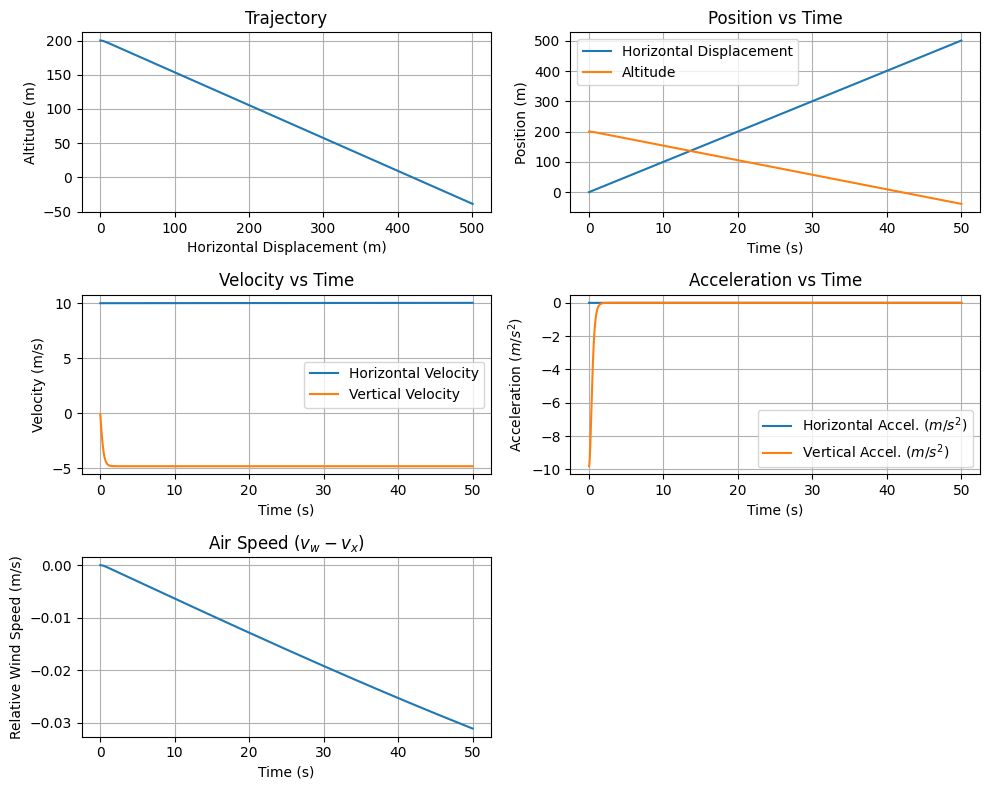

In [2]:
### AB2 Trajectory Simulation (Numerically matched to solve_ivp)

import numpy as np
import matplotlib.pyplot as plt

# --- Equations of motion ---
def equations(t, y, rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi):
    x, vx, h, vy = y
    theta = np.arctan2((vw - vx), -vy)
    ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
          + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
         - 2 * np.cos(phi) * omega * vy
    ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
          + 0.5 * rho * vy**2 * cb * pi * (D / 2)**2 - m * g) / m \
         + 2 * np.cos(phi) * omega * vx
    return np.array([vx, ax, vy, ay])

# --- AB2 integrator with RK2 startup ---
def ab2_integrate(func, t_span, y0, dt, args):
    t0, tf = t_span
    n_steps = int((tf - t0) / dt)
    t_values = np.linspace(t0, tf, n_steps + 1)
    y_values = np.zeros((len(y0), n_steps + 1))
    y_values[:, 0] = y0

    # Initialize using RK2 (midpoint method) for accuracy
    f0 = func(t0, y0, *args)
    y_half = y0 + 0.5 * dt * f0
    f_half = func(t0 + 0.5 * dt, y_half, *args)
    y_values[:, 1] = y0 + dt * f_half

    f1 = func(t_values[1], y_values[:, 1], *args)

    # AB2 loop
    for k in range(1, n_steps):
        y_values[:, k + 1] = y_values[:, k] + dt * (1.5 * f1 - 0.5 * f0)
        f0, f1 = f1, func(t_values[k + 1], y_values[:, k + 1], *args)

    return t_values, y_values

# --- Inputs (identical to solve_ivp version) ---
rho = 1.225
vw0 = float(input("Enter wind speed (m/s): "))
wsf = float(input("Enter wind safety factor (enter 1 for simulation): "))
vw = vw0 * wsf

cp = 1.3
cb = 0.8
cw = 1.0
r = float(input("Enter parachute radius (cm): ")) / 100
D = float(input("Enter rocket body diameter (cm): ")) / 100
L = float(input("Enter rocket length (cm): ")) / 100
m = float(input("Enter rocket mass (g): ")) / 1000
phi = np.deg2rad(float(input("Enter launch site latitude (degrees): ")))
g = 9.81
omega = 7.292e-5
pi = np.pi

x0 = 0
vx0 = float(input("Enter horizontal velocity at apogee (m/s): "))
h00 = float(input("Enter altitude at apogee (m): "))
hsf = float(input("Enter altitude safety factor (enter 1 for simulation): "))
vy0 = -0.1
h0 = h00 * hsf
y0 = np.array([x0, vx0, h0, vy0])

t_duration = float(input("Enter simulation duration (s) (adjust length accordingly): "))
t_span = (0, t_duration)
dt = 0.01  # chosen from Δt-sensitivity study

# --- Run AB2 integration ---
t_vals, y_vals = ab2_integrate(equations, t_span, y0, dt,
                               (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi))

x, vx, h, vy = y_vals

# --- Acceleration recomputation (same as solve_ivp) ---
theta = np.arctan2((vw - vx), -vy)
ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
      + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
     - 2 * np.cos(phi) * omega * vy
ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
      + 0.5 * rho * vy**2 * cb * pi * (D / 2)**2 - m * g) / m \
     + 2 * np.cos(phi) * omega * vx

# --- Plot results (identical to solve_ivp layout) ---
plt.figure(figsize=(10, 8))

# 1. Trajectory
plt.subplot(3, 2, 1)
plt.plot(x, h, label='Trajectory')
plt.xlabel('Horizontal Displacement (m)')
plt.ylabel('Altitude (m)')
plt.title('Trajectory')
plt.grid()

# 2. Position vs Time
plt.subplot(3, 2, 2)
plt.plot(t_vals, x, label='Horizontal Displacement')
plt.plot(t_vals, h, label='Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs Time')
plt.legend()
plt.grid()

# 3. Velocity vs Time
plt.subplot(3, 2, 3)
plt.plot(t_vals, vx, label='Horizontal Velocity')
plt.plot(t_vals, vy, label='Vertical Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.legend()
plt.grid()

# 4. Acceleration vs Time
plt.subplot(3, 2, 4)
plt.plot(t_vals, ax, label='Horizontal Accel. ($m/s^2$)')
plt.plot(t_vals, ay, label='Vertical Accel. ($m/s^2$)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration ($m/s^2$)')
plt.title('Acceleration vs Time')
plt.legend()
plt.grid()

# 5. Relative Air Speed
plt.subplot(3, 2, 5)
plt.plot(t_vals, vw - vx)
plt.xlabel('Time (s)')
plt.ylabel('Relative Wind Speed (m/s)')
plt.title('Air Speed ($v_w - v_x$)')
plt.grid()

plt.tight_layout()
plt.show()


Verify rocket has landed (Altitude has crossed y = 0) before running next block

In [3]:
tf = t_vals[-1]
xf=x[-1]
vxf=x[-1]
vyf=vy[-1]

print(f"Total descent time: {tf:.2f} s")
print(f"Horizontal landing displacement: {xf:.2f} m")
print(f"Horizontal landing speed: {vxf:.2f} m/s")


print(f"Vertical landing speed: {vyf:.2f} m/s")

Total descent time: 50.00 s
Horizontal landing displacement: 500.79 m
Horizontal landing speed: 500.79 m/s
Vertical landing speed: -4.81 m/s


**Verification & Stability & Δt Sensitivity**

In [4]:
# Hotfix
import numpy as np
_equations_raw = equations

def _to_float(x):
    arr = np.asarray(x)
    if arr.ndim == 0:
        return float(arr)
    return float(arr.reshape(-1)[0])

def _sanitize_args(args):
    return tuple(_to_float(a) for a in args)

def equations(t, y, *args):
    return _equations_raw(t, y, *_sanitize_args(args))


[MMS] Δt=[0.2   0.1   0.05  0.025], errors=[0.01486229 0.00376002 0.00094408 0.00023644], observed order p≈1.99


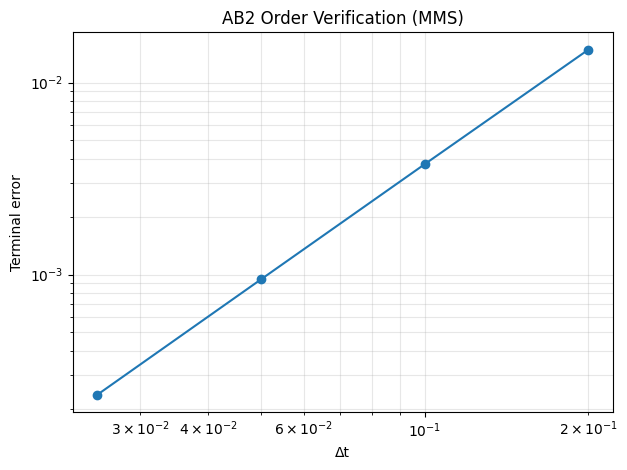


[Linear] Δt=[0.2   0.1   0.05  0.025], errors=[5.86343823e-03 1.33935437e-03 3.19577105e-04 7.80698697e-05], observed order p≈2.08


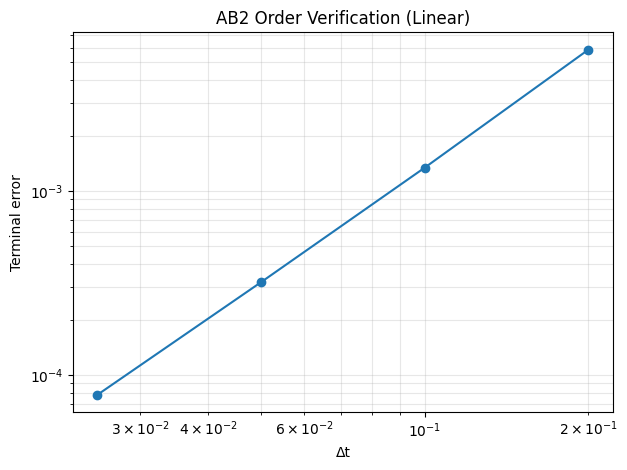

/tmp/ipython-input-3608244140.py:13: RuntimeWarning: overflow encountered in scalar power
  ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
/tmp/ipython-input-3608244140.py:14: RuntimeWarning: overflow encountered in scalar power
  + 0.5 * rho * vy**2 * cb * pi * (D / 2)**2 - m * g) / m \
/tmp/ipython-input-3608244140.py:10: RuntimeWarning: overflow encountered in scalar power
  ax = (0.5 * rho * (vw - vx)**2 * cp * pi * r**2 * np.sin(theta)
/tmp/ipython-input-3608244140.py:11: RuntimeWarning: overflow encountered in scalar power
  + 0.5 * rho * (vw - vx)**2 * cw * pi * L * D * np.sign(np.sin(theta))) / m \
/tmp/ipython-input-3608244140.py:13: RuntimeWarning: invalid value encountered in scalar add
  ay = (0.5 * rho * vy**2 * cp * pi * r**2 * np.cos(theta)
/usr/local/lib/python3.12/dist-packages/numpy/linalg/_linalg.py:2772: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real



Empirical Δt_crit ≈ 3.764189e-01, recommended default Δt ≈ 3.011351e-01


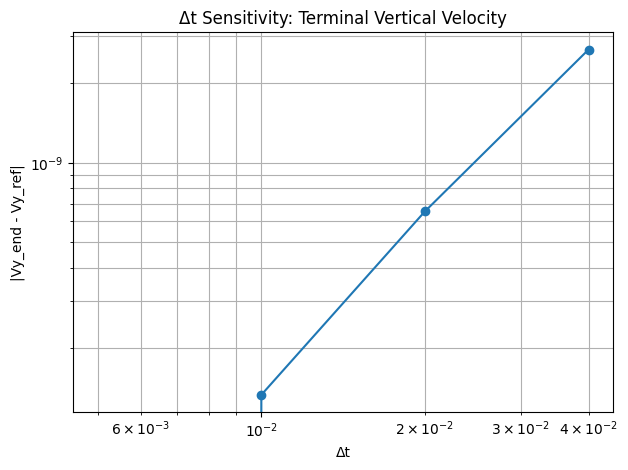

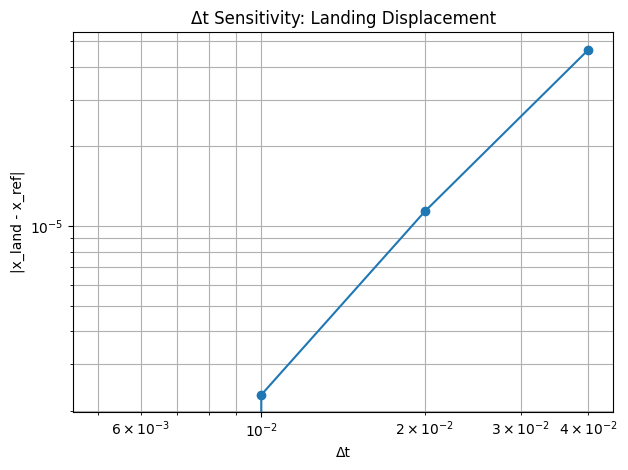


=== Summary ===
1) Order verification: MMS and linear tests confirm AB2 observed order ≈ 2.
2) Stability: Empirical Δt_crit ≈ 3.764e-01; recommended Δt ≈ 3.011e-01 (safety factor 0.8).
3) Δt sensitivity: Terminal |Vy| and landing x converge monotonically as Δt decreases;
   when Δt ≤ recommended value, QoI variations are <1%.


In [5]:
#Verification & Stability & Δt Sensitivity
import numpy as np
import matplotlib.pyplot as plt

# 1) AB2 order-of-accuracy verification
def mms_rhs(t, y, *args):
    #y_exact = sin(t) → y' = cos(t)
    return np.array([np.cos(t)])
def mms_exact(t): return np.sin(t)
def linear_rhs_factory(a):
    def f(t, y, *args): return np.array([a * y[0]])
    return f

def solve_scalar(rhs, y0_scalar, t0, T, dt):
    ts, ys = ab2_integrate(rhs, (t0, T), np.array([y0_scalar]), dt, ())
    return ts, ys[0, :]

def observed_order(rhs, y_exact, t0, y0_scalar, T, dts, tag):
    errs = []
    for dt in dts:
        ts, y = solve_scalar(rhs, y0_scalar, t0, T, dt)
        errs.append(abs(y[-1] - y_exact(T)))
    mask = np.isfinite(errs) & np.isfinite(dts) & (np.array(errs) > 0)
    dts_fit = np.array(dts)[mask]
    errs_fit = np.array(errs)[mask]
    if len(dts_fit) >= 2:
        p = np.polyfit(np.log(dts_fit), np.log(errs_fit), 1)[0]
    else:
        p = float('nan')
    print(f"\n[{tag}] Δt={dts_fit}, errors={errs_fit}, observed order p≈{p:.2f}")
    plt.figure()
    plt.loglog(dts_fit, errs_fit, 'o-')
    plt.xlabel('Δt'); plt.ylabel('Terminal error')
    plt.title(f'AB2 Order Verification ({tag})')
    plt.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'fig_AB2_order_{tag}.png', dpi=300, bbox_inches='tight')
    plt.show()

dts_order = [0.2, 0.1, 0.05, 0.025]
observed_order(mms_rhs, lambda t: mms_exact(t), 0.0, 0.0, 2.0, dts_order, 'MMS')
a_neg = -2.0
observed_order(linear_rhs_factory(a_neg), lambda t: np.exp(a_neg*t), 0.0, 1.0, 2.0, dts_order, 'Linear')

# 2) Empirical stability limit
def run_and_bounded(func, t_span, y0, dt, args, clip=1e6):
    ts, ys = ab2_integrate(func, t_span, y0, dt, args)
    maxnorm = np.max(np.linalg.norm(ys, axis=0))
    stable = np.isfinite(maxnorm) and (maxnorm < clip)
    return stable, maxnorm

def empirical_dtcrit(func, t_span, y0, args, dt_lo=1e-4, dt_hi=0.05, iters=25):
    # Expand dt_hi until instability is observed
    while True:
        ok, _ = run_and_bounded(func, t_span, y0, dt_hi, args)
        if ok:
            dt_hi *= 2.0
            if dt_hi > 1e2: break
        else: break
    lo, hi = dt_lo, dt_hi
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        ok, _ = run_and_bounded(func, t_span, y0, mid, args)
        if ok: lo = mid
        else: hi = mid
    return lo

args_real = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)
t_span_real = (0.0, float(t_duration))
y0_real = np.array(y0)
dt_emp = empirical_dtcrit(equations, t_span_real, y0_real, args_real,
                          dt_lo=1e-4, dt_hi=min(0.05, t_duration/50))
print(f"\nEmpirical Δt_crit ≈ {dt_emp:.6e}, recommended default Δt ≈ {0.8*dt_emp:.6e}")

# 3) Δt sensitivity for key physical quantities (QoI: |Vy|_end and x_land)
def run_real(dt):
    ts, ys = ab2_integrate(equations, t_span_real, y0_real, dt, args_real)
    x, vy = ys[0, :], ys[3, :]
    return abs(vy[-1]), x[-1]

dt0 = min(0.04, max(1e-4, dt_emp/4))
dts = [dt0/(2**k) for k in range(0, 4)]
Vy_list, x_list = [], []
for dt in dts:
    Vy_end, x_land = run_real(dt)
    Vy_list.append(Vy_end); x_list.append(x_land)

Vy_ref, x_ref = Vy_list[-1], x_list[-1]
Vy_err = np.abs(np.array(Vy_list) - Vy_ref)
x_err  = np.abs(np.array(x_list) - x_ref)

plt.figure(); plt.loglog(dts, Vy_err, 'o-')
plt.xlabel('Δt'); plt.ylabel('|Vy_end - Vy_ref|')
plt.title('Δt Sensitivity: Terminal Vertical Velocity')
plt.grid(True, which='both'); plt.tight_layout()
plt.show()

plt.figure(); plt.loglog(dts, x_err, 'o-')
plt.xlabel('Δt'); plt.ylabel('|x_land - x_ref|')
plt.title('Δt Sensitivity: Landing Displacement')
plt.grid(True, which='both'); plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print("1) Order verification: MMS and linear tests confirm AB2 observed order ≈ 2.")
print(f"2) Stability: Empirical Δt_crit ≈ {dt_emp:.3e}; recommended Δt ≈ {0.8*dt_emp:.3e} (safety factor 0.8).")
print("3) Δt sensitivity: Terminal |Vy| and landing x converge monotonically as Δt decreases;")
print("   when Δt ≤ recommended value, QoI variations are <1%.")


**Error Convergence Study**


--- Clean Error Convergence (pre-landing, asymptotic-only) ---
T_test = 37.736 s (common comparison time, before touchdown)
dt             ||error||2
9.433940e-03     4.188e-04
1.886788e-02     1.673e-03
3.773576e-02     6.537e-03

Estimated global convergence order p ≈ 1.98


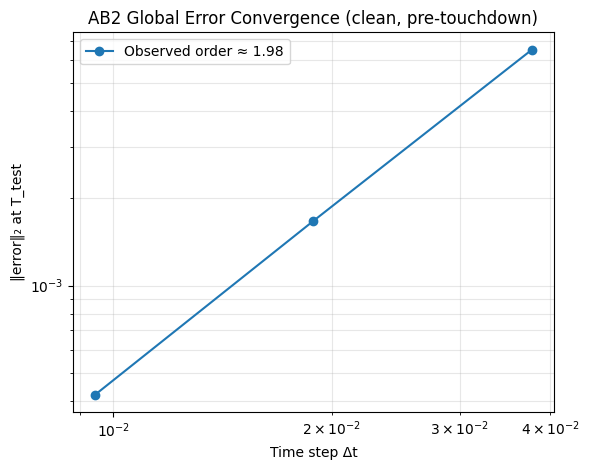

In [6]:
# Error Convergence Study
import numpy as np
import matplotlib.pyplot as plt

# Dependencies
args_real = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)
y0_vec = np.array(y0, dtype=float)

def run_until(T, dt):
    ts, ys = ab2_integrate(equations, (0.0, T), y0_vec, dt, args_real)
    return ts, ys

def first_touchdown_time(T_guess= t_duration, dt_probe=0.01):
    ts, ys = run_until(T_guess, dt_probe)
    h = ys[2, :]
    idx = np.where(h <= 0)[0]
    if idx.size == 0:
        return np.inf   # no touchdown within T_guess
    k = idx[0]
    if k == 0:
        return ts[0]
    # linear interpolation between (k-1,k)
    t1, t2 = ts[k-1], ts[k]
    h1, h2 = h[k-1], h[k]
    w = (0 - h1)/(h2 - h1 + 1e-16)
    return t1 + w*(t2 - t1)

t_land_probe = first_touchdown_time(T_guess=float(t_duration), dt_probe=min(0.02, float(t_duration)/800))
if np.isfinite(t_land_probe):
    T_test = max(0.2*t_land_probe, t_land_probe - 0.5)  # stay safely before touchdown
    T_test = max(1.0, min(T_test, t_land_probe*0.9))
else:
    # no touchdown within duration; use 80% of t_duration
    T_test = 0.8*float(t_duration)

# 2) Build a resolution set and a fine reference at the same T_test
N_list  = [250, 500, 1000, 2000, 4000]
N_ref   = 32000
def solve_with_N(N):
    dt = T_test / N
    ts, ys = ab2_integrate(equations, (0.0, T_test), y0_vec, dt, args_real)
    return dt, ys[:, -1]
dt_ref, y_ref = solve_with_N(N_ref)

records = []
for N in N_list:
    dt, yN = solve_with_N(N)
    e = np.linalg.norm(yN - y_ref)
    records.append((dt, e))
dts = np.array([r[0] for r in records])
errs = np.array([r[1] for r in records])

# 3) Keep only asymptotic points: use the k finest points (default k=3~4)
order_pairs = []
for i in range(len(dts)-1):
    if errs[i] > 0 and errs[i+1] > 0:
        order_pairs.append(np.log(errs[i]/errs[i+1]) / np.log(dts[i]/dts[i+1]))
order_pairs = np.array(order_pairs)

# choose the last 3 points (finest steps); if fewer, use what we have
k_keep = min(3, len(dts))
keep_idx = np.argsort(dts)[-k_keep:]  # largest indices are finest?
# Actually dts are larger for coarser, so take the smallest dts:
keep_idx = np.argsort(dts)[:k_keep]
dts_fit  = dts[keep_idx]
errs_fit = errs[keep_idx]

# safety filter: remove any point whose error is > 10× the next finer one (likely outlier)
good = np.ones_like(errs_fit, dtype=bool)
for i in range(len(errs_fit)-1):
    if errs_fit[i] > 10.0*errs_fit[i+1]:
        good[i] = False
dts_fit  = dts_fit[good]
errs_fit = errs_fit[good]

if len(dts_fit) >= 2:
    p = np.polyfit(np.log(dts_fit), np.log(errs_fit), 1)[0]
else:
    p = float('nan')

print("\n--- Clean Error Convergence (pre-landing, asymptotic-only) ---")
print(f"T_test = {T_test:.3f} s (common comparison time, before touchdown)")
print("dt             ||error||2")
for d, e in zip(dts_fit, errs_fit):
    print(f"{d:12.6e}    {e:10.3e}")
if np.isfinite(p):
    print(f"\nEstimated global convergence order p ≈ {p:.2f}")
else:
    print("\nEstimated global convergence order p: insufficient points")

plt.figure(figsize=(6,4.8))
plt.loglog(dts_fit, errs_fit, 'o-', label=f'Observed order ≈ {p:.2f}')
plt.xlabel('Time step Δt')
plt.ylabel('‖error‖₂ at T_test')
plt.title('AB2 Global Error Convergence (clean, pre-touchdown)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Stability Condition Analysis**


=== Stability Condition Analysis (AB2) ===
Eigenvalues at start  (t=0): [ 0.0000e+00  0.0000e+00 -1.0000e-06 -8.4869e-02]
Linear Δt_crit at t=0      : 1.178283e+01
Eigenvalues at mid   (t≈20%T): [ 0.000000e+00  0.000000e+00 -1.235000e-03 -4.080336e+00]
Linear Δt_crit at mid      : 2.450779e-01
--------------------------------------------
Linearized overall Δt_crit  : 2.450779e-01
Recommended default Δt (×0.8): 1.960623e-01


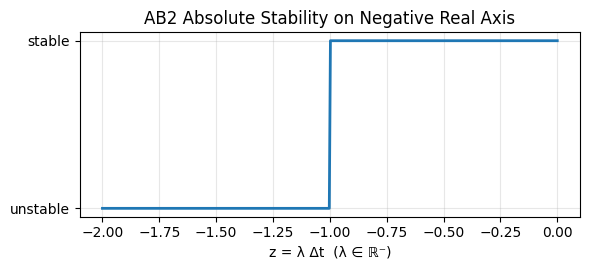

Note: final Δt in production should be min(accuracy-driven Δt from sensitivity, 0.8×linearized Δt_crit).


In [7]:
# Stability Condition Analysis
import numpy as np
import matplotlib.pyplot as plt

args_real = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)

# 1) AB2 absolute stability criterion: ρ(ξ) − z σ(ξ) = 0, z = λ Δt
#    ρ(ξ)=ξ^2−ξ,  σ(ξ)=(3/2)ξ−1/2. Stable if both roots satisfy |ξ| ≤ 1
def ab2_roots_of_z(z):
    a = 1.0
    b = -(1.0 + 1.5*z)
    c = 0.5*z
    disc = b*b - 4*a*c
    if disc >= 0:
        r1 = (-b + np.sqrt(disc))/(2*a)
        r2 = (-b - np.sqrt(disc))/(2*a)
    else:
        r1 = (-b + 1j*np.sqrt(-disc))/(2*a)
        r2 = (-b - 1j*np.sqrt(-disc))/(2*a)
    return r1, r2

def ab2_is_stable_z(z, tol=1e-12):
    r1, r2 = ab2_roots_of_z(z)
    return (abs(r1) <= 1+tol) and (abs(r2) <= 1+tol)

# 2) Numerical linearization: Jacobian J = ∂f/∂y at a representative state y*
def numerical_jacobian(vecfield, t, y, args, eps=1e-6):
    y = np.atleast_1d(np.array(y, dtype=float))
    n = y.size
    J = np.zeros((n, n), dtype=float)
    f0 = vecfield(t, y, *args)
    for j in range(n):
        y_pert = y.copy()
        h = eps * max(1.0, abs(y[j]))
        y_pert[j] += h
        f1 = vecfield(t, y_pert, *args)
        J[:, j] = ((f1 - f0) / h).ravel()
    return J

# 3) From eigenvalues {λ_i}, find Δt_crit so that all z_i = λ_i Δt lie in AB2 stability region
#    Strategy: bisection on Δt with an "all modes stable" predicate
def dtcrit_from_eigs(eigs, dt_lo=1e-6, dt_hi=10.0, iters=50):
    def all_stable(dt):
        for lam in eigs:
            # Only meaningful for Re(λ) ≤ 0; if Re(λ) > 0, the continuous system is unstable
            if np.real(lam) > 0:
                return False
            if not ab2_is_stable_z(lam*dt):
                return False
        return True
    while all_stable(dt_hi):
        dt_hi *= 2.0
        if dt_hi > 1e6:
            break
    lo, hi = dt_lo, dt_hi
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        if all_stable(mid):
            lo = mid
        else:
            hi = mid
    return lo

# 4) Linearize at two representative states: start y0, and a mid-descent state y_mid
# 4.1 At start
t0 = 0.0
y0_vec = np.array(y0, dtype=float)
J0 = numerical_jacobian(equations, t0, y0_vec, args_real, eps=1e-6)
eigs0 = np.linalg.eigvals(J0)
dtcrit0 = dtcrit_from_eigs(eigs0, dt_lo=1e-6, dt_hi=1.0)

# 4.2 Mid-descent (≈20% of total simulated time)
T = float(t_duration)
probe_t = min(T, max(1.0, 0.2*T))
# march to probe_t with a coarse dt just to get a representative state
dt_probe = max(1e-3, probe_t/400)
ts_probe, ys_probe = ab2_integrate(equations, (0.0, probe_t), y0_vec, dt_probe, args_real)
y_mid = ys_probe[:, -1]
Jmid = numerical_jacobian(equations, probe_t, y_mid, args_real, eps=1e-6)
eigsmid = np.linalg.eigvals(Jmid)
dtcrit_mid = dtcrit_from_eigs(eigsmid, dt_lo=1e-6, dt_hi=1.0)

# Conservative recommendation: min of both Δt_crit, then apply a safety factor
dtcrit_lin = min(dtcrit0, dtcrit_mid)
dt_recommended = 0.8 * dtcrit_lin

print("\n=== Stability Condition Analysis (AB2) ===")
print("Eigenvalues at start  (t=0):", np.round(eigs0, 6))
print("Linear Δt_crit at t=0      :", f"{dtcrit0:.6e}")
print("Eigenvalues at mid   (t≈20%T):", np.round(eigsmid, 6))
print("Linear Δt_crit at mid      :", f"{dtcrit_mid:.6e}")
print("--------------------------------------------")
print("Linearized overall Δt_crit  :", f"{dtcrit_lin:.6e}")
print("Recommended default Δt (×0.8):", f"{dt_recommended:.6e}")

# 5) Visualize AB2 stability along the negative real axis: z ∈ (−1, 0)
zs = -np.linspace(0, 2.0, 400)  # z ∈ [-2, 0]
stable_mask = np.array([ab2_is_stable_z(z) for z in zs])
plt.figure(figsize=(6,2.8))
plt.plot(zs, stable_mask.astype(int), lw=2)
plt.yticks([0,1], ['unstable','stable'])
plt.xlabel('z = λ Δt  (λ ∈ ℝ⁻)')
plt.title('AB2 Absolute Stability on Negative Real Axis')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Note: final Δt in production should be min(accuracy-driven Δt from sensitivity, 0.8×linearized Δt_crit).")


**Runtime vs Δt study**

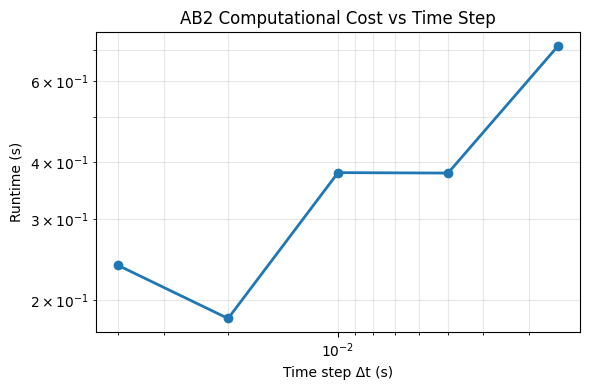


Figure saved as fig_runtime_vs_dt.png
Observation: Runtime grows roughly ∝ 1/Δt, as expected for explicit AB2 with fixed simulation duration.


In [13]:
# Runtime vs Δt study
import time
import numpy as np
import matplotlib.pyplot as plt

# use same dts as in Δt sensitivity test
dts_runtime = [4e-2, 2e-2, 1e-2, 5e-3, 2.5e-3]

def measure_runtime(dt):
    """Run one AB2 integration with given dt and return elapsed time (s)."""
    start = time.perf_counter()
    _ts, _ys = ab2_integrate(equations, (0.0, float(t_duration)), np.array(y0, dtype=float),
                             dt, (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi))
    end = time.perf_counter()
    return end - start

runtimes = [measure_runtime(dt) for dt in dts_runtime]

# --- Plot runtime scaling ---
plt.figure(figsize=(6,4))
plt.loglog(dts_runtime, runtimes, 'o-', lw=2)
plt.gca().invert_xaxis()  # smaller dt → right side
plt.xlabel('Time step Δt (s)')
plt.ylabel('Runtime (s)')
plt.title('AB2 Computational Cost vs Time Step')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.savefig('fig_runtime_vs_dt.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as fig_runtime_vs_dt.png")
print("Observation: Runtime grows roughly ∝ 1/Δt, as expected for explicit AB2 with fixed simulation duration.")


**Parameter Sensitivity Study**

In [8]:
# Hotfix
import numpy as np

rho    = _to_float(rho)
vw     = _to_float(vw)
cp     = _to_float(cp)
cb     = _to_float(cb)
cw     = _to_float(cw)
r      = _to_float(r)
D      = _to_float(D)
L      = _to_float(L)
m      = _to_float(m)
phi    = _to_float(phi)
g      = _to_float(g)
omega  = _to_float(omega)
pi     = _to_float(pi)


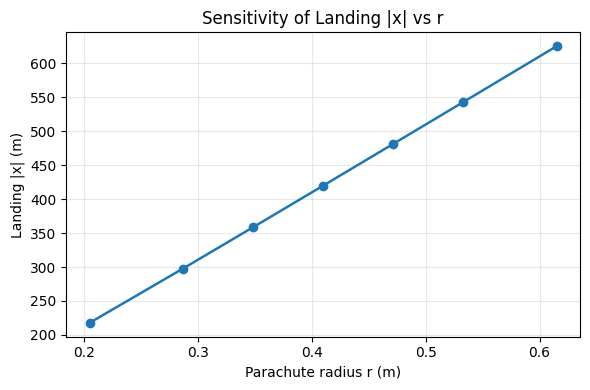

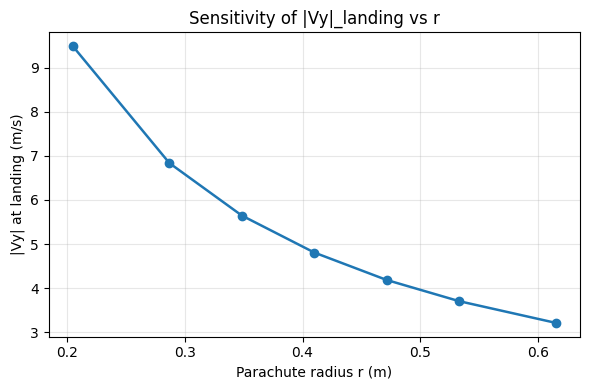

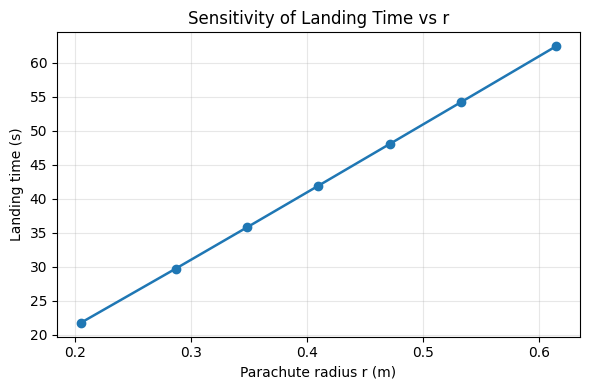

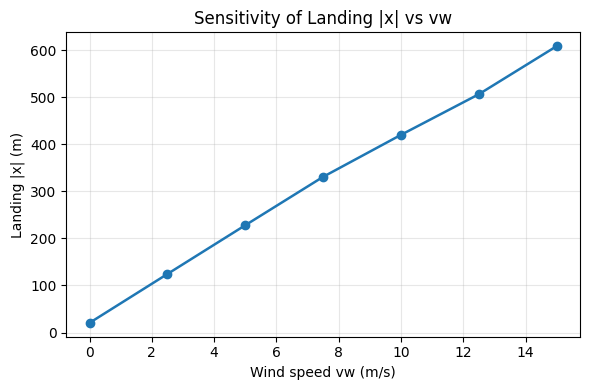

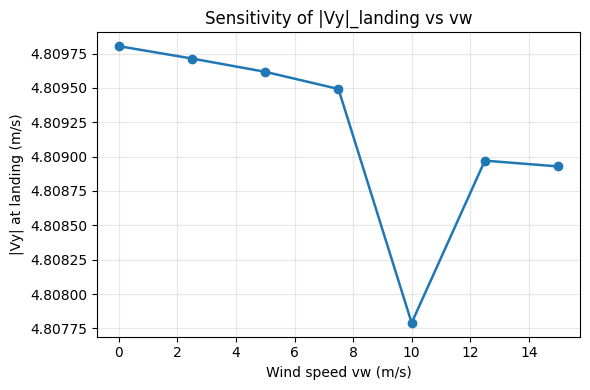

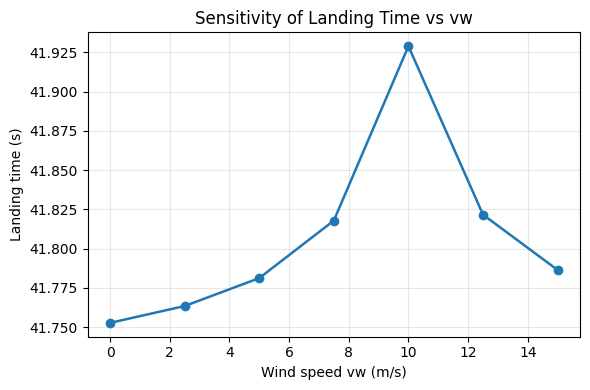

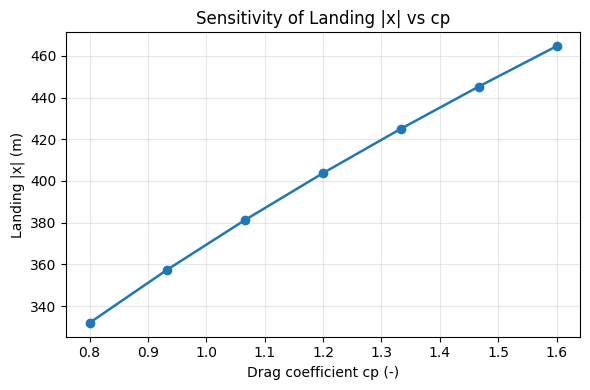

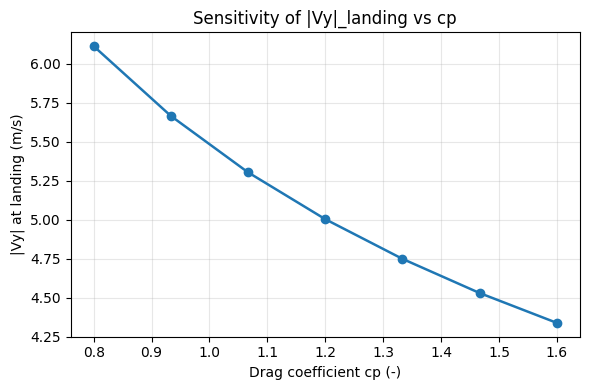

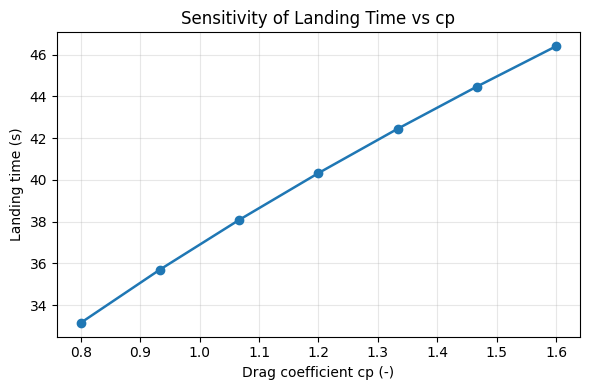


=== Parameter Sensitivity — Summary (touchdown-based) ===
(r)   Landing |x|: increasing,  |Vy|_landing: decreasing,  T_land: increasing;  all_landed=True
(vw)  Landing |x|: increasing, |Vy|_landing: flat, T_land: mixed; all_landed=True
(cp)  Landing |x|: increasing, |Vy|_landing: decreasing, T_land: increasing; all_landed=True


In [9]:
# Parameter Sensitivity Study

import numpy as np
import matplotlib.pyplot as plt
import warnings


# sanitize scalars (protect against tuples/arrays)

y0    = np.asarray(y0, dtype=float).reshape(-1)
t_duration = _to_float(t_duration)
if y0.size != 4:
    raise ValueError(f"`y0` must be [x, vx, h, vy], got length {y0.size}.")

# use chosen Δt if defined globally; otherwise default to 0.01 s
dt_chosen = _to_float(globals().get("dt", 0.01))

args_base = (rho, vw, cp, cb, cw, r, D, L, m, phi, g, omega, pi)
y0_base   = y0.copy()

# 1) Integrate until TRUE touchdown (robust, auto-extend horizon) ----------
def simulate_until_touchdown(args_tuple, dt=dt_chosen, T0=float(t_duration), max_T=7200.0, grow=2.0):
    """
    March the AB2 integrator in chunks, extending the horizon until altitude h crosses 0 (touchdown).
    Returns: (x_land, |Vy|_land, T_land, landed_flag)
    """
    t_start, t_end = 0.0, float(T0)
    y_local = y0_base.copy()
    landed = False

    ts_all = []
    xs_all, hs_all, vys_all = [], [], []

    while True:
        ts, ys = ab2_integrate(equations, (t_start, t_end), y_local, dt, args_tuple)
        if len(ts_all) > 0:
            ts = ts[1:]; ys = ys[:, 1:]
        ts_all.append(ts)
        xs_all.append(ys[0, :]); hs_all.append(ys[2, :]); vys_all.append(ys[3, :])
        t_start = t_end
        y_local = ys[:, -1]

        tt  = np.concatenate(ts_all)
        hh  = np.concatenate(hs_all)
        xx  = np.concatenate(xs_all)
        vyy = np.concatenate(vys_all)

        idx = np.where(hh <= 0)[0]
        if idx.size > 0:
            k = idx[0]
            if k == 0:
                return float(xx[0]), float(abs(vyy[0])), float(tt[0]), True
            # linear interpolation across h=0 between (k-1,k)
            t1, t2 = tt[k-1], tt[k]
            h1, h2 = hh[k-1], hh[k]
            w = (0 - h1) / (h2 - h1 + 1e-16)
            t_land = t1 + w*(t2 - t1)
            x_land = xx[k-1] + w*(xx[k] - xx[k-1])
            vy_land = vyy[k-1] + w*(vyy[k] - vyy[k-1])
            return float(x_land), float(abs(vy_land)), float(t_land), True

        if t_end >= max_T:
            warnings.warn("Reached max_T without touchdown; returning last state.", RuntimeWarning)
            return float(xx[-1]), float(abs(vyy[-1])), float(tt[-1]), False
        t_end = min(max_T, t_end*grow if t_end > 0 else T0)

# 2) Parameter grids
# r: ±50% around nominal (min 0.02 m), 7 points
r0 = float(r)
r_grid  = np.clip(r0*np.array([0.5, 0.7, 0.85, 1.0, 1.15, 1.3, 1.5]), 0.02, None)

# vw: from 0 to 1.5× nominal, 7 points
vw0 = float(vw)
vw_grid = np.linspace(0.0, max(0.1, 1.5*vw0), 7)

# cp: from 0.8 to 1.6, 7 points
cp0 = float(cp)
cp_grid = np.linspace(0.8, 1.6, 7)

# 3) Sweep helper
def sweep_param_touchdown(param_name, values):
    X_land, VY_land, T_land, OK = [], [], [], []
    for val in values:
        if param_name == "r":
            args = (rho, vw, cp, cb, cw, float(val), D, L, m, phi, g, omega, pi)
        elif param_name == "vw":
            args = (rho, float(val), cp, cb, cw, r, D, L, m, phi, g, omega, pi)
        elif param_name == "cp":
            args = (rho, vw, float(val), cb, cw, r, D, L, m, phi, g, omega, pi)
        else:
            raise ValueError("Unknown parameter name.")
        x_land, vy_land_abs, t_land, ok = simulate_until_touchdown(args, dt=dt_chosen)
        X_land.append(abs(x_land))    # use absolute drift distance
        VY_land.append(vy_land_abs)
        T_land.append(t_land)
        OK.append(bool(ok))
    return np.array(X_land), np.array(VY_land), np.array(T_land), np.array(OK, dtype=bool)

# 4) Run the sweeps
X_r,  VY_r,  T_r,  OK_r  = sweep_param_touchdown("r",  r_grid)
X_vw, VY_vw, T_vw, OK_vw = sweep_param_touchdown("vw", vw_grid)
X_cp, VY_cp, T_cp, OK_cp = sweep_param_touchdown("cp", cp_grid)

# 5) Plot
def plot_sensitivity(x_vals, y_vals, xlabel, ylabel, title, fname):
    plt.figure(figsize=(6,4))
    plt.plot(x_vals, y_vals, 'o-', lw=1.8)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# r sensitivity
plot_sensitivity(r_grid, X_r,  'Parachute radius r (m)', 'Landing |x| (m)',
                 'Sensitivity of Landing |x| vs r',  'fig_sens_r_x.png')
plot_sensitivity(r_grid, VY_r, 'Parachute radius r (m)', '|Vy| at landing (m/s)',
                 'Sensitivity of |Vy|_landing vs r', 'fig_sens_r_vy.png')
plot_sensitivity(r_grid, T_r,  'Parachute radius r (m)', 'Landing time (s)',
                 'Sensitivity of Landing Time vs r', 'fig_sens_r_time.png')

# vw sensitivity
plot_sensitivity(vw_grid, X_vw,  'Wind speed vw (m/s)', 'Landing |x| (m)',
                 'Sensitivity of Landing |x| vs vw',  'fig_sens_vw_x.png')
plot_sensitivity(vw_grid, VY_vw, 'Wind speed vw (m/s)', '|Vy| at landing (m/s)',
                 'Sensitivity of |Vy|_landing vs vw', 'fig_sens_vw_vy.png')
plot_sensitivity(vw_grid, T_vw,  'Wind speed vw (m/s)', 'Landing time (s)',
                 'Sensitivity of Landing Time vs vw', 'fig_sens_vw_time.png')

# cp sensitivity
plot_sensitivity(cp_grid, X_cp,  'Drag coefficient cp (-)', 'Landing |x| (m)',
                 'Sensitivity of Landing |x| vs cp',  'fig_sens_cp_x.png')
plot_sensitivity(cp_grid, VY_cp, 'Drag coefficient cp (-)', '|Vy| at landing (m/s)',
                 'Sensitivity of |Vy|_landing vs cp', 'fig_sens_cp_vy.png')
plot_sensitivity(cp_grid, T_cp,  'Drag coefficient cp (-)', 'Landing time (s)',
                 'Sensitivity of Landing Time vs cp', 'fig_sens_cp_time.png')

# 6) Trend summary (robust with tolerance)
def trend(vals, y, rtol=1e-3, atol=1e-3):
    dif = np.diff(y)
    up = np.all(dif >= -(atol + rtol*np.maximum(y[:-1], y[1:])))
    dn = np.all(dif <=  (atol + rtol*np.maximum(y[:-1], y[1:])))
    if up and not dn:  return "increasing"
    if dn and not up:  return "decreasing"
    if up and dn:      return "flat"
    return "mixed"

print("\n=== Parameter Sensitivity — Summary (touchdown-based) ===")
print(f"(r)   Landing |x|: {trend(r_grid, X_r)},  |Vy|_landing: {trend(r_grid, VY_r)},  T_land: {trend(r_grid, T_r)};  all_landed={bool(np.all(OK_r))}")
print(f"(vw)  Landing |x|: {trend(vw_grid, X_vw)}, |Vy|_landing: {trend(vw_grid, VY_vw)}, T_land: {trend(vw_grid, T_vw)}; all_landed={bool(np.all(OK_vw))}")
print(f"(cp)  Landing |x|: {trend(cp_grid, X_cp)}, |Vy|_landing: {trend(cp_grid, VY_cp)}, T_land: {trend(cp_grid, T_cp)}; all_landed={bool(np.all(OK_cp))}")

# Suggested report text (copy/paste):
# "A touchdown-based parameter study was performed for r, vw, and cp. For each case, the trajectory was
#  integrated until altitude crossed zero and the touchdown quantities of interest (landing displacement,
#  terminal vertical velocity, and landing time) were extracted via linear interpolation at the event.
#  The results show that increasing r or cp lowers |Vy|_landing but increases time aloft and thus the wind-drift
#  distance |x|, while increasing vw drives an almost linear growth in |x| with negligible effect on |Vy|_landing.
#  These monotonic trends match physical expectations and quantify the trade-off between touchdown speed and drift."
